In [31]:
   %load_ext autoreload
   %autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:

from ErrP_decoder.data_io import select_eeg_files, load_selected_files

file_paths = select_eeg_files()

datasets = load_selected_files(file_paths)

for ds in datasets:
    print("Data shape:", ds.data.shape)
    print("Info:", ds.info)

Extracting EDF parameters from /Users/hililbby/Library/Mobile Documents/com~apple~CloudDocs/UT Austin/JM rotation/ErrP_decoder/data/subject2/subject100_1.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
AF3, AF4, F3, F1, FZ, F2, F4, FC3, FC1, FCZ, FC2, FC4, C3, C1, CZ, C2, C4, CP3, CP1, CPZ, CP2, CP4, P3, P1, PZ, P2, P4, PO3, POZ, PO4, O1, O2, sens7, sens8, sens9
Creating raw.info structure...
Reading 0 ... 282111  =      0.000 ...   550.998 secs...
Extracting EDF parameters from /Users/hililbby/Library/Mobile Documents/com~apple~CloudDocs/UT Austin/JM rotation/ErrP_decoder/data/subject2/subject100_2.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
AF3, AF4, F3, F1, FZ, F2, F4, FC3, FC1, FCZ, FC2, FC4, C3, C1, CZ, C2, C4, CP3, CP1, CPZ, CP2, CP4, P3, P1, PZ, P2, P4, PO3, POZ, PO4, O1, O2, sens7, sen

In [33]:
from ErrP_decoder.data_io import set_params
for ds in datasets:
    cfg = set_params(ds.info,config_path="../configs/default.yaml")

In [34]:
from ErrP_decoder.data_io import preprocess_dataset
for ds in datasets:
    ds = preprocess_dataset(ds, cfg)

for ds in datasets:
    neu = sum(ds.trig['typ'] == 0)
    pos = sum(ds.trig['typ'] == 1)
    neg = sum(ds.trig['typ'] == 2)
    print(neu)
    print(pos)
    print(neg)
    


175
25
0
167
33
0
160
40
0
171
29
0
174
26
0


In [35]:
from ErrP_decoder.data_io import bandpass_filter
from ErrP_decoder.plots import plot_eeg_interactive

for ds in datasets:
    filtered_eeg = bandpass_filter(ds.eeg,cfg)
    plot_eeg_interactive(filtered_eeg, cfg)
    ds.eeg_filt = filtered_eeg

interactive(children=(IntSlider(value=0, continuous_update=False, description='Page', max=276992, step=5120), …

interactive(children=(IntSlider(value=0, continuous_update=False, description='Page', max=235520, step=5120), …

interactive(children=(IntSlider(value=0, continuous_update=False, description='Page', max=233472, step=5120), …

interactive(children=(IntSlider(value=0, continuous_update=False, description='Page', max=232960, step=5120), …

interactive(children=(IntSlider(value=0, continuous_update=False, description='Page', max=231424, step=5120), …

In [36]:
from ErrP_decoder.data_io import epoch_data
for ds in datasets:
    ds.epochs, ds.epoch_labels = epoch_data(ds.eeg_filt,cfg,ds.trig)
    ds.epochs = ds.epochs.transpose(1, 2, 0)
    # epochs (768,32,200)
    # epoch_labels (200,)

In [37]:
import numpy as np

all_epochs = []
all_labels = []
for ds in datasets:
    all_epochs.append(ds.epochs)
    all_labels.append(ds.epoch_labels)
# Concatenate along the epochs axis (axis=2 for epochs, axis=0 for labels)
epochs_combined = np.concatenate(all_epochs, axis=2)
labels_combined = np.concatenate(all_labels, axis=0)

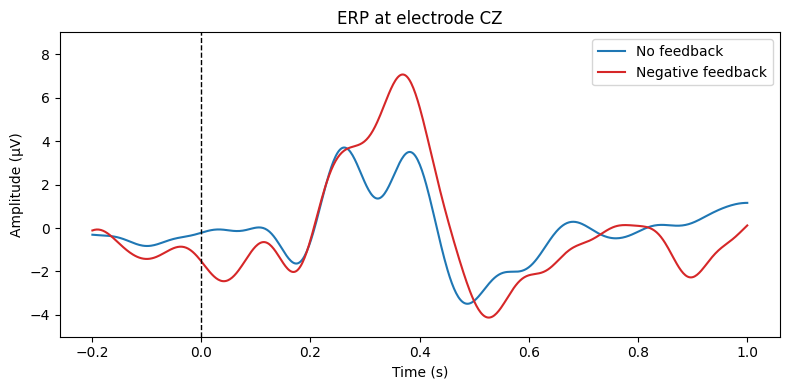

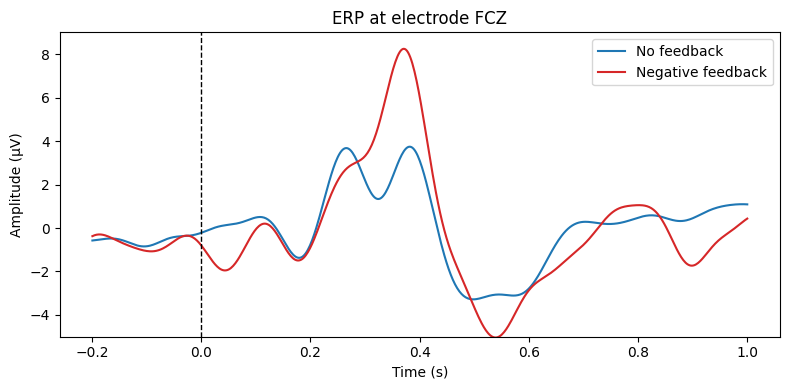

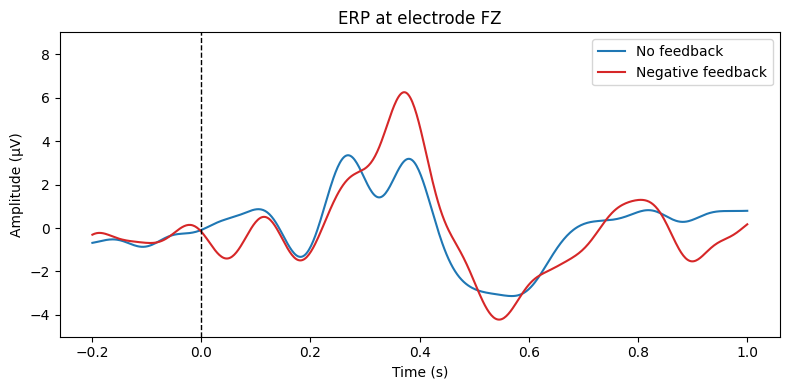

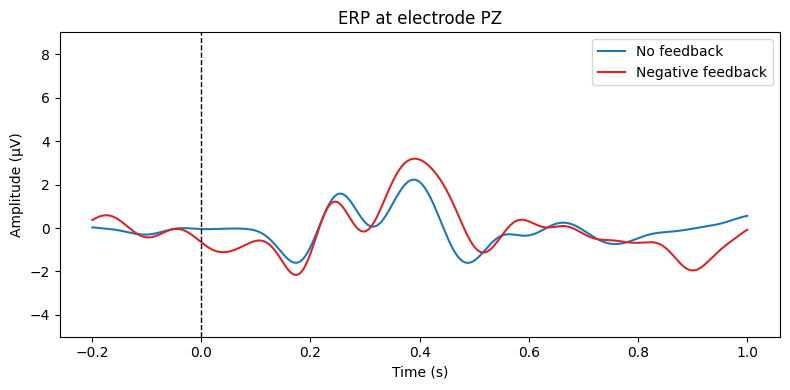

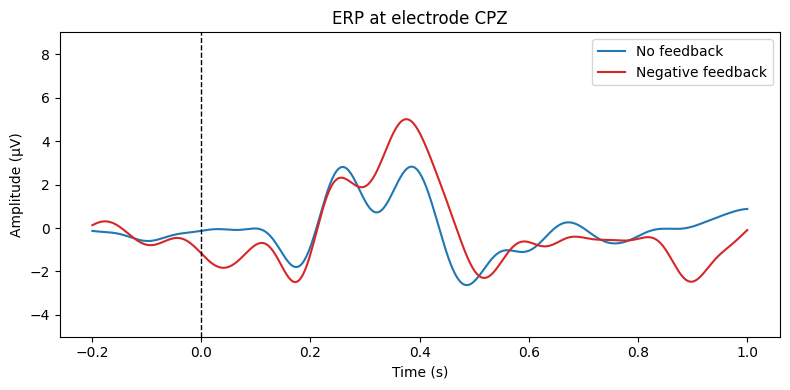

In [38]:
from ErrP_decoder.plots import plot_erp
plot_erp(epochs_combined, labels_combined, cfg, 'CZ')
plot_erp(epochs_combined, labels_combined, cfg, 'FCZ')
plot_erp(epochs_combined, labels_combined, cfg, 'FZ')
plot_erp(epochs_combined, labels_combined, cfg, 'PZ')
plot_erp(epochs_combined, labels_combined, cfg, 'CPZ')

In [39]:
from ErrP_decoder.data_io import balance_runs
for ds in datasets:
    ds.epochs_balanced, ds.epoch_labels_balanced = balance_runs(ds.epochs,ds.epoch_labels)

In [40]:
for ds in datasets:
    print(ds.epochs_balanced.shape)


(768, 32, 50)
(768, 32, 66)
(768, 32, 80)
(768, 32, 58)
(768, 32, 52)


In [41]:

all_epochs = []
all_labels = []
run_labels = []

for i, ds in enumerate(datasets):
    all_epochs.append(ds.epochs_balanced)              # shape: (samples, channels, trials)
    all_labels.append(ds.epoch_labels_balanced)        # shape: (trials,)

    n_trials = ds.epoch_labels_balanced.shape[0]
    run_labels.append(np.full(n_trials, i))            # start from 0

training_epochs   = np.concatenate(all_epochs, axis=2)   # shape: (768,32,306)
training_labels = np.concatenate(all_labels, axis=0)   # shape: (306,)
training_run_labels = np.concatenate(run_labels, axis=0)   # shape: (306,)
train_data = {
    'data' : training_epochs,
    'labels' : training_labels,
    'run' : training_run_labels
}



In [42]:
all_epochs = []
all_labels = []
run_labels = []

for i, ds in enumerate(datasets):
    all_epochs.append(ds.epochs)              # shape: (samples, channels, trials)
    all_labels.append(ds.epoch_labels)        # shape: (trials,)

    n_trials = ds.epoch_labels.shape[0]
    run_labels.append(np.full(n_trials, i))   # start from 0

test_epochs   = np.concatenate(all_epochs, axis=2)   # shape: (768,32,1000)
test_labels = np.concatenate(all_labels, axis=0)   # shape: (1000,)
test_run_labels = np.concatenate(run_labels, axis=0)   # shape: (1000,)
test_data = {
    'data' : test_epochs,
    'labels' : test_labels,
    'run' : test_run_labels
}

In [43]:
from ErrP_decoder.modeling import leave_one_run_out_cv
posteriors = leave_one_run_out_cv(train_data, test_data, cfg)

In [45]:
from ErrP_decoder.evaluation import evaluate_classifier
evaluate_classifier(test_data['labels'], posteriors)

== Synchronous Classification == 
AUC score : 0.58   Threshold: 0.50
Confusion Matrix:
[[484 363]
 [ 69  84]]
TNR: 0.57   TPR: 0.55


{'fpr': array([0.        , 0.00118064, 0.00354191, 0.00354191, 0.00826446,
        0.00826446, 0.01062574, 0.01062574, 0.01534829, 0.01534829,
        0.02007084, 0.02007084, 0.02243211, 0.02243211, 0.02597403,
        0.02597403, 0.04132231, 0.04132231, 0.04250295, 0.04250295,
        0.04486423, 0.04486423, 0.05903188, 0.05903188, 0.06021251,
        0.06021251, 0.06257379, 0.06257379, 0.06375443, 0.06375443,
        0.08382527, 0.08382527, 0.09563164, 0.09563164, 0.10153483,
        0.10153483, 0.10507674, 0.10507674, 0.10625738, 0.10625738,
        0.10743802, 0.10743802, 0.11216057, 0.11216057, 0.11806375,
        0.11806375, 0.14285714, 0.14285714, 0.14521842, 0.14521842,
        0.14994097, 0.14994097, 0.15230224, 0.15230224, 0.15820543,
        0.15820543, 0.16174734, 0.16174734, 0.16292798, 0.16292798,
        0.19244392, 0.19244392, 0.19598583, 0.19598583, 0.19834711,
        0.19834711, 0.20779221, 0.20779221, 0.22077922, 0.22077922,
        0.23022432, 0.23022432, 0.2373081

In [ ]:
from ErrP_decoder.evaluation import plot_posteriors_by_class
plot_posteriors_by_class(test_data['labels'], posteriors, 
                         class_names=['No Feedback', 'Negative Feedback'], bins=20)

                            COMPUTE DECODER FUNCTIONS TESTING BELOW

In [29]:
from ErrP_decoder.modeling import compute_decoder

decoder = decoder = compute_decoder(training_data, training_labels, cfg)

In [12]:
from ErrP_decoder.modeling import get_cca_spatialfilter

spatial_filter = get_cca_spatialfilter(training_data, training_labels, 
                                       n_components=cfg['spatial_filter']['n_comp']) # shape (32,2)



In [13]:

from ErrP_decoder.modeling import apply_spatial_filter
filtered_data = apply_spatial_filter(training_data, spatial_filter) # shape: (samples, n_components, trials)

In [14]:
from ErrP_decoder.modeling import resample_epochs
resampled = resample_epochs(filtered_data,cfg) # shape (20, 3, 306)


In [26]:
n_samples, n_comp, n_trials = resampled.shape
X = resampled.reshape(n_samples * n_comp, n_trials).T # shape: (samples, features) e.g. (306,60)
y = training_labels # shape: (samples, ) e.g. (306,)


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

print("LDA coefficients shape:", lda.coef_.shape)       # (n_classes-1, n_features)
print("LDA intercepts shape:", lda.intercept_.shape)